# Cloud Map of EIA Today in Energy Titles via Web Scraping
The U.S. Energy Information Administration (EIA) publishes <a href="https://www.eia.gov/todayinenergy/about.php">*Today in Energy* </a> articles, which are brief, informative analyses covering various energy topics. Here we do some basic web scraping and make a cloud map of the words in the article titles.
Note: web scraping should always be performed in a way that follows the website's terms and conditions and abides by copyright and other laws.

In [11]:
# import libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

## Define extraction function to get webpage data

In [12]:
# archive articles are on different pages organized by year, so we scrap from multiple urls
def extract(start_year,end_year):
    table_attrs = ['date','href','article_title']
    df = pd.DataFrame(columns=table_attrs)
    # loop through years and create dataframe
    for yr in range(start_year,end_year+1):
        url = 'https://www.eia.gov/todayinenergy/archive.php?my='+str(yr)
        page = requests.get(url).text
        data = BeautifulSoup(page,'html.parser')
        for li in data.find_all('li'): #info are in the lists
            data_dict = {'date':'','href':'','article_title':''} #dict to hold data
            for sp in li.find_all('span', {'class':'date'}): #date is in span
                data_dict.update({'date':sp.text})
            for a in li.find_all('a', href=True):
                data_dict.update({'href':a['href'], # getting href will help filter data to get only titles
                                  'article_title':a.text}) #title of article
                df1 = pd.DataFrame(data_dict, index=[0])
                df = pd.concat([df,df1], ignore_index=True)
    return df

## Define transform function to clean up the data

In [13]:
def transform(df1):
    df2 = df1[df1['href'].str.contains('detail')].copy() #those with 'detail' in href are an article
    df2.loc[:,'date'] = pd.to_datetime(df2.loc[:,'date']) #make date format
    df2.loc[:,'article_title'] = df2.loc[:,'article_title'].str.lower() #make lower case
    df2 = df2[['date','article_title']] # keep just date and title
    return df2

## Define function to make the word cloud

In [14]:
def make_cloud(df):
    title_words = ''
    # words we don't want to show up on  cloud
    ignore_words = ['could','but','be','been','with','were','by','since', "isn't", 'ours', 'there','than','on', 'our', 'have','to', 'for', 'last',
                    'from', 'its','than','will','year','the', 'a', 'in', 'is', 'it', 'of', 'after', 'are',
                    'and', 'or', 'was', 'an', 'as', 'what', 'which', 'this', 'now','set', 'highlight', 'pre']
    # convert dataframe column of titles to a single string
    for title in df['article_title']:
        title_ls = title.split()
        words = [x for x in title_ls if x not in ignore_words]
        title_words += ' '.join(words)+' '
    # clean some special words so they show up correct
    title_words = title_words.replace('u.s.', 'US')
    title_words = title_words.replace('greenhouse gas', 'greenhousegas')
    title_words = title_words.replace('natural gas', 'naturalgas')
    title_words = title_words.replace('crude oil', 'crudeoil') # just going to push these together to 
    mask = np.array(Image.open(r'us_map.png')) # get US map image for background
    mask[mask == 0] = 255
    cloud = WordCloud(width=4000,height=4000,background_color='white', normalize_plurals=False, 
                      collocations=False, stopwords=['s'], mask=mask).generate(title_words)
    plt.figure(figsize=(12,12))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return

## Call the functions to make the word cloud

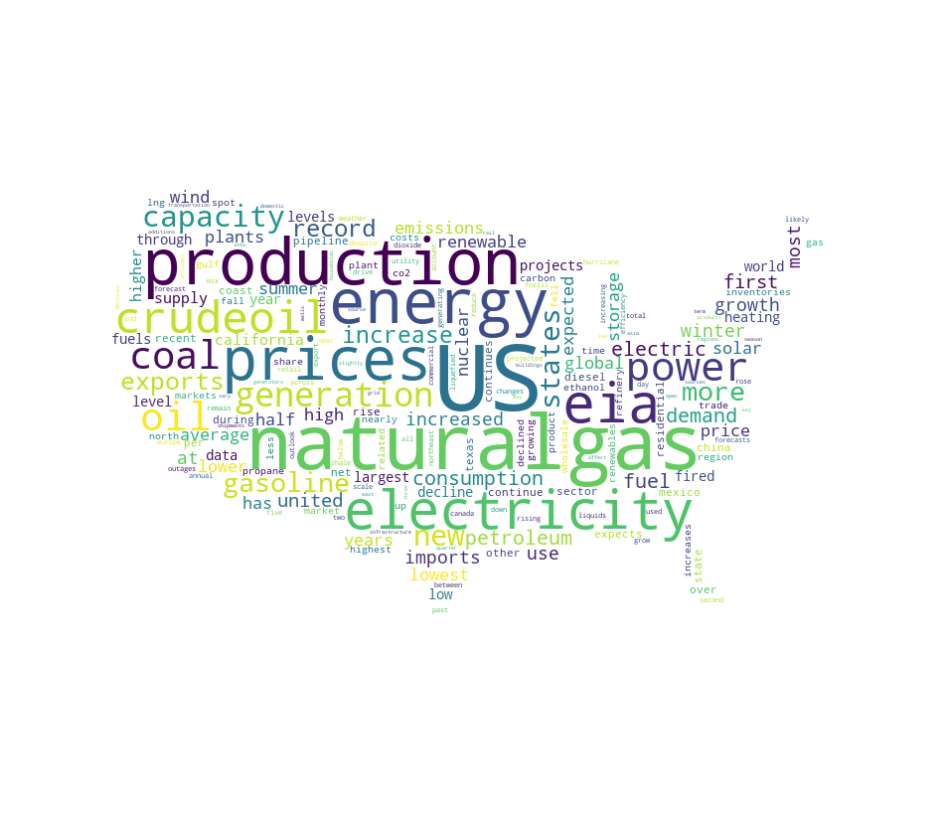

In [15]:
raw_df = extract(start_year=2011,end_year=2023)
clean_df = transform(raw_df)
make_cloud(clean_df)